In [1]:
from skimage import io,color, filters
import numpy as np
import cv2
import glob
import imutils,pytesseract



In [2]:

def plate_detection_morphological_operations(thresh):
    thresh = cv2.erode(thresh, None, iterations=3)
    thresh = cv2.dilate(thresh, None, iterations=8)
    thresh = cv2.erode(thresh, None, iterations=1)
    thresh = cv2.dilate(thresh, None, iterations=7)
    thresh = cv2.erode(thresh, None, iterations=1)
    return thresh

def plate_detection(img):
    img = cv2.resize(img,(800,600))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    SE = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, SE) 
    light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    grad_x = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad_x = np.absolute(grad_x)
    (minVal, maxVal) = (np.min(grad_x), np.max(grad_x))
    grad_x = 255 * ((grad_x - minVal) / (maxVal - minVal))
    grad_x = grad_x.astype("uint8")
    grad_x = cv2.GaussianBlur(grad_x, (5, 5), 0)
    grad_x = cv2.morphologyEx(grad_x, cv2.MORPH_CLOSE, kernel)

    thresh = cv2.threshold(grad_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = plate_detection_morphological_operations(thresh)

    result_img = cv2.bitwise_and(thresh, thresh, mask=light)
    result_img = cv2.dilate(result_img, None, iterations=8)
    result_img = cv2.erode(result_img, None, iterations=1)
    # io.imshow(result_img)
    # io.show()

    contours = cv2.findContours(result_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

    license_plate = None
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        ratio = w / float(h)
        if 1.2 < ratio < 4.0:
            if (w > 100 and w < 300) and (h > 25 and h < 100):
                license_plate = contour
                break

    if license_plate is not None:
        mask = np.zeros(gray.shape, dtype="uint8")
        (x, y, w, h) = cv2.boundingRect(license_plate)
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
        mask = cv2.bitwise_and(gray, gray, mask=mask)
        # io.imshow(mask)
        # io.show()

        license_plate = cv2.minMaxLoc(mask)[3]
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[y:y + h, x:x + w]
    
    return None


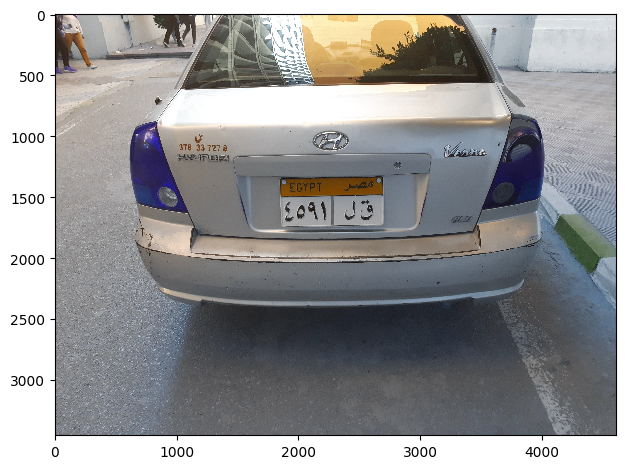

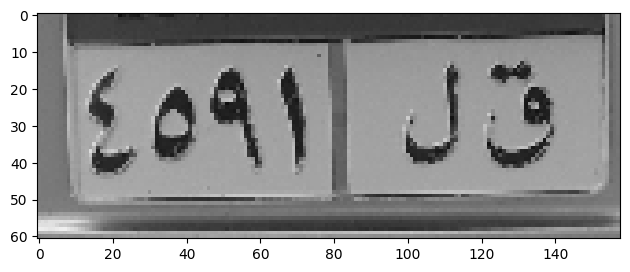

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [3]:
for img in sorted(glob.glob('InputImages/*.jpg')):
    car_img = cv2.imread(img)
    io.imshow(car_img)
    io.show()

    plate_img = plate_detection(car_img)

    if plate_img is not None:
        io.imshow(plate_img)
        io.show()
        text = pytesseract.image_to_string(plate_img, lang='eng')
        print(text)